**Recitation 6**

    FIRE_YEAR = Calendar year in which the fire was discovered or confirmed to exist.
    
    STATE = Two-letter alphabetic code for the state in which the fire burned (or originated).
    
    LATITUDE = Latitude (NAD83) for point location of the fire (decimal degrees).
    
    LONGITUDE = Longitude (NAD83) for point location of the fire (decimal degrees).
    
    FIRE_SIZE = Estimate of acres within the final perimeter of the fire.
    
    FIRE_SIZE_CLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).

**The outline of this recitation is as follows:**

(i) Data imputation using OpenCage geolocator API

  - Some records in the database are missing a value for STATE but have values for LATITUDE and LONGITUDE. We will impute the missing value for STATE with LATITUDE and LONGITUDE using a Google geolocator API.
    
(ii) Visualizations using SQL queries via Python

  - We will call upon SQL queries in Python with the help of a useful software library called Pandas (to be explained later) and then conduct exploratory data analysis by creating time series plots and histograms.
    
(iii) Extensions with geo shapes
  - We will use an extension of Pandas, GeoPandas, along with spatial data to see how we can combine datapoints with spatial features such as urban areas and generate useful summaries of fire statistics by geographic area.

**How and what to submit:**




--------------------------------------------------------------------------------------------------------------------------------------------------------

**Set up**

This lab is written to be run in Google colab. Running in Google colab avoids issues with packages conflicting with each other. There are other ways to overcome this in other python environments, but we won't worry about that here.



As mentioned, we will be using a geolocater API. The process of converting longitude and latitude into street address, for example, is called reverse geocoding. To fully utilize the API, we will first need a API key.

Go to https://opencagedata.com/api and create a free acount using your Cornell or personal email.

Once you are logged in and on "Your Dashboard," click on the `API Keys` button and copy key. We'll need it later.

*Importing necessary libraries*



* **sqlite3** - For our purposes, we will use the library solely to connect to a SQLite database, allowing us to make queries on a database of interest. In our case, we will make a connection with the "Wildfires.sqlite" database and run SQL queries all from Python. 

* **pandas** - is a widely used data manipulation and analysis library written for Python. One of its primary objects is dataframes, which are similar to SQLite tables: rows and columns in dataframes are analogous to records and features in SQLite tables. We will primarily be using Pandas to return a dataframe of a query result on a SQLite database.

* **matplotlib.pyplot** - let's us plot the dataframes we obtained from our SQL-Pandas integration from above. 

*Note:* The **as** function simply abbreviates the library name, so that whenever we call upon the library, we only have to reference an abbreviation (e.g. *pd* as opposed to *pandas* ).

In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import IPython

# Graph Styling
plt.rcParams["figure.figsize"] = (10,10)  # Sets the figure size to be larger than the default
plt.rcParams['axes.labelsize'] = 14       # Sets The axis labels
plt.rcParams['xtick.labelsize'] = 12      # Sets the x-axis tick marker labels
plt.rcParams['ytick.labelsize'] = 12      # Sets the y-axis tick marker labels

*Connecting to SQLite database*

If the following line of code fails, it is because Wildfires.sqlite hasn't been uploaded yet. Make sure to follow the step at the start of the recitation to upload this.



In [9]:
# Double check that Wildfires.sqlite has been uploaded to colab
assert(os.path.isfile('Wildfires.sqlite'))
# Connecting to Wildfires database
conn = sq.connect('Wildfires.sqlite')

In [7]:
!pip install opencage
from opencage.geocoder import OpenCageGeocode

"""
ENTER YOUR KEY BELOW, 
"""
key = '4fd146a1ac1543c0b0ea29b395bccea3'
if key == '':
  raise Exception('Change API key string. Be sure to follow the instructions above')

def get_state_code(lat,longs):
    geocoder = OpenCageGeocode(key)
    results = geocoder.reverse_geocode(lat, longs)
    return results[0]['components']['state_code']

     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 3.2MB 10.6MB/s 


In this dataset, some of the states are missing. This might be because of data collection issues or because the file was modified at some point during its history.

Let's start by understanding how many records are missing. We do this by running a query that counts the number of missing records, putting the results in a dataframe, and then printing out this dataframe. Python prints this dataframe because it is the output of the last command in the cell.

*pd.read_sql_query([query], conn)* - is a function that reads the SQL query and returns a pandas dataframe. Here is an example of how it is used.
[query] should be one long string containing the entire query.

In [10]:
pd.read_sql_query("select count(*) from fires where state IS NULL",conn)

,count(*)
0,376


**Question #1:** How many records have missing states?




```

376 records have missing states

This is a small fraction of the data, but it's large enough to cause problems. We'll fix this by filling in the missing values. This is called "imputing" the data. To do this, we create a query that gets all the records whose states have null values and saves that into a pandas "dataframe". 



**Question #2:** Write a line of code that saves this SQL query "select objectid, latitude, longitude from fires where state IS NULL" into a pandas dataframe named "missing_df"

In [ ]:
# Enter the line of code below and run it

In [13]:
missing_df=pd.read_sql_query("select objectid, latitude, longitude from fires where state IS NULL",conn)

In [14]:
#Run this and make sure your dataframe looks good
missing_df.head()

,OBJECTID,LATITUDE,LONGITUDE
0,5000,48.356944,-117.614722
1,10000,41.137778,-123.285833
2,15000,43.167778,-121.966111
3,20000,44.364444,-120.334167
4,25000,38.931111,-119.976389


**Time to impute the data**

Before we get started, here are important terms and functions for queries that modify SQL tables.

* *conn.cursor()* - returns a "cursor". A cursor is an object that keeps track of a connection to an SQL database.

* *cursor.execute([query])* - uses the cursor to execute queries. We will run queries that use UPDATE, allowing us to modify the SQL table. [query] should be one long string containing the entire query.

* *conn.commit()* - once an UPDATE query is sent to the database by *cursor.execute()*, we then need to "commit" the changes before they will appear in the database. If there is an error before *conn.commit()* is called, causing the commit to not happen, then none of the changes actually show up in the database.

* *pandas.dataframe.iterrows()* - within a for loop, as shown below, allows us to perform operations on one row at a time from a DataFrame.  This is described in more detail below. 

In [16]:
# Here is an example of cursor, execute, and commit.

# This inserts a fake record into the database
cur = conn.cursor()
cur.execute("INSERT INTO Fires VALUES (-1, 'NY', 23.221, -14.3444, 2020, 150, 'A')")
conn.commit()

# Also, note that strings can be defined with either single quotes or double quotes.
# We used double quotes above because we wanted to write a string that 
# contains single quotes. 
# The following line, where we swap single quotes for double quotes
# and vice versa, would be equally valid as the one above:
# cur.execute('INSERT INTO Fires VALUES (-1, "NY", 23.221, -14.3444, 2020, 150, "A")')

# This should show one record with the values inserted above
print(pd.read_sql_query("select * from fires where objectid = -1",conn))

cur = conn.cursor()
cur.execute("UPDATE Fires SET latitude = 79 WHERE objectid = -1")
conn.commit()

# Now the record should have a latitude of 79
print(pd.read_sql_query("SELECT * FROM Fires WHERE objectid = -1",conn))

# Drop the column that was just added
cur = conn.cursor()
cur.execute("DELETE FROM Fires WHERE objectid = -1")
conn.commit()

# This should return no records (i.e. an empty DataFrame)
print(pd.read_sql_query("select * from fires where objectid = -1",conn))

   OBJECTID state  LATITUDE  LONGITUDE  FIRE_YEAR  FIRE_SIZE FIRE_SIZE_CLASS
0        -1    NY    23.221   -14.3444       2020      150.0               A
   OBJECTID state  LATITUDE  LONGITUDE  FIRE_YEAR  FIRE_SIZE FIRE_SIZE_CLASS
0        -1    NY      79.0   -14.3444       2020      150.0               A
Empty DataFrame
Columns: [OBJECTID, state, LATITUDE, LONGITUDE, FIRE_YEAR, FIRE_SIZE, FIRE_SIZE_CLASS]
Index: []


In [17]:
# Here is an example with iterrows()
short_df = missing_df[missing_df['OBJECTID']<20000] # filter so that we don't print out too many rows
for index, row in short_df.iterrows():
  # row is a single row from missing_df. You can access values from that row 
  # using square brackets, just as we would with a full dataframe.  For example, 
  # row['LATITUDE'] contains that row's value for latitude.
  # We are changing the type of the objectid and latitude to strings with str()
  # so that we can concatenate them with other strings before printing
  print('This row has objectid ' + str(row['OBJECTID']))
  print('This row has latitude ' + str(row['LATITUDE']) + ' and longitude ' + str(row['LATITUDE']))


This row has objectid 5000.0
This row has latitude 48.35694444 and longitude 48.35694444
This row has objectid 10000.0
This row has latitude 41.13777778 and longitude 41.13777778
This row has objectid 15000.0
This row has latitude 43.16777778 and longitude 43.16777778



We will now fill in missing data. We will operate on one row from missing_df at a time using *iterrows()*. For each row, we will first call the *get_state_code()* function defined above to obtain the correct state code from the fire's latitude and longitude. We will then modify the value in the original table to use this state code by executing an "UPDATE" query.

Once you write the code, running it will take approximately 3 minutes. You can monitor the progress by using a print function.

**Question #3**: Lets write the imputation function. Part of it has been filled in for you.

In [29]:
cur = conn.cursor()
for index, row in missing_df.iterrows():
    # create a string, called impute_query, that contains an SQL UPDATE command.
    # This command should update the record whose objectid is row[0]
    code = get_state_code(row['LATITUDE'],row['LONGITUDE'])
    impute_query = 'UPDATE Fires SET STATE ="'+ code +'" WHERE Fires.objectid='+str(row[0]) 
    cur.execute(impute_query)

    # This code tracks the progress of your imputation.
    IPython.display.clear_output()
    print("[" + str(index+1) + "/376] completed || Currently processing ObjectID = " + str(row[0]))

    
conn.commit()

[376/376] completed || Currently processing ObjectID = 1880000.0


If all went well, we should now have no missing state fields in our fires table. Let's re-run the query we used before to check the number of missing records. 

**Question #4**: Copy the query for checking missing records and code for running it from above to the cell below. Then check that the number of missing records is 0. If it is not 0, there was a flaw in the imputation we did above. So, continue ONLY if you get 0.

In [31]:
#Enter answer here
pd.read_sql_query("select count(*) from fires where state IS NULL",conn)

,count(*)
0,0


Good work ! We now have completed the first objective in the recitation outline. This means we have a complete dataset moving forward.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Exploratory Data Analysis**

Recall, we will be focusing on the table "Fires" in the Wildfires.sqlite database. It contains essential information about the fire including but not limited to – name, location, size. For purposes of this recitation, we will also focus on 4 states: New York ("NY"), California ("CA"), Texas ("TX"), and Alaska ("AK").

First, let's start by plotting the number of fires occurring each year statewise. We will do this plot for you as an example, please familiarize yourself with the code.

In [32]:
# Defining the list of state to iterate over it
States = ["NY", "CA", "TX", "AK"]

In [33]:
# This code iterates over each state, and runs a query that counts the number of fires in the state in a year, 
# and then creates a dataframe, which is added to a dictionary whose index is the abbrevation for the state.
# dates_dfs is a dictionary that has dataframes in it
dates_dfs = {}
for state in States:
    dates_query = "select state, fire_year, count(*) from fires where state is '" + state  + "' group by fire_year"
    dates_dfs[state] = pd.read_sql_query(dates_query,conn)

In [34]:
#Lets take a look at how one of the elements in the dictionary looks
dates_dfs["NY"].head()

,state,FIRE_YEAR,count(*)
0,NY,1992,364
1,NY,1993,304
2,NY,1994,129
3,NY,1995,487
4,NY,1996,107


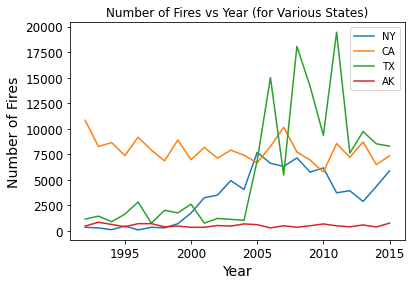

In [35]:
# .iloc[] (or, "index locator") is a function that retrieves records within a range of indices. 
# Here, .iloc[:,1] retrieves a column of all records and their value for the 1st column (FIRE_YEAR in this case)
# Similarily, iloc[:,2] retrieves a column of all records and their value for the 2nd column (COUNT(*) in this case)
for state in States:
    plt.plot(dates_dfs[state].iloc[:,1], dates_dfs[state].iloc[:,2])

plt.legend(States)
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.title("Number of Fires vs Year (for Various States)")
plt.show()

**Question #5:** We see something interesting in the histogram. One state seems like it has the least number of fires. Which state is this ?



```

*Alaska*

However, this can be misleading. Lets explore a little more. 

**Question #6:** Particularly, write some python code, similar to what we wrote above, that plots the average fire size in each state against time (year). Lets do this in a couple steps.

In [83]:
# Write a string representing a query that selects state, fire_year, average fire size from fires and group it by state and year.
# average fire size = sum of fire_size/ total rows grouped by state and fire year
size_query = 'select state, fire_year, sum(fire_size)/count(fire_size) as avg_fire_size from fires group by state, fire_year'

# Read this query into a pandas dataframe
size_df = pd.read_sql_query(size_query,conn)

In [80]:
sizes_dfs = {}
# Write code that iterates over each state, and runs a new query to create dataframes to add to dictionary sizes_dfs = {}
# Refer the code that was used to create the previous graph if you have trouble

for state in States:
    query='select state, fire_year, sum(fire_size)/count(fire_size) as avg_fire_size from fires where state is"' + state+ '" group by state, fire_year'
    sizes_dfs[state] = pd.read_sql_query(query,conn)

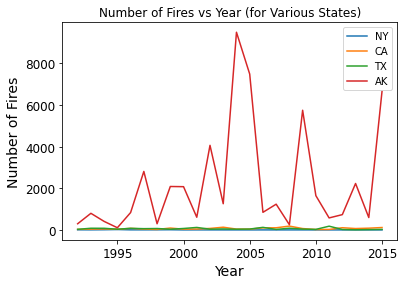

In [82]:
# Now create a plot similar to before

for state in States:
    plt.plot(sizes_dfs[state].iloc[:,1], sizes_dfs[state].iloc[:,2])

plt.legend(States)
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.title("Number of Fires vs Year (for Various States)")
plt.show()

It is interesting that even though Alaska has much fewer reported wildfires, the size of those wildfires are much larger when compared to other states. The discrepancy between the number of wildfires and the intensity of those wildfires for these particular states motivates us to examine the overall distribution of fire sizes in the dataset. Fortunately, the fire sizes are also classified by a "class" (lettered from A to G with A being the smallest and G being the largest), so we can examine the dataset through convenient categorical bins.

Like before, we use *pd.read_sql_query([query], conn)* to read a SQL query and return a pandas dataframe. 

In [84]:
size_class_query = "select fire_size_class , count(*) from fires group by fire_size_class"
size_class_df = pd.read_sql_query(size_class_query,conn)

Now we plot the resulting dataframe *size_class_df* into a bar graph as follows.

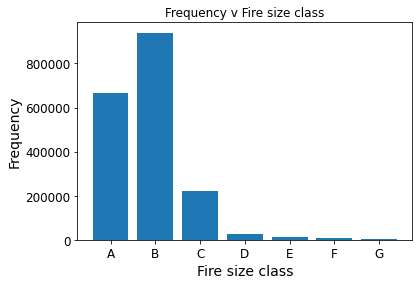

In [85]:
# plt.bar(x,y) plots a bar graph of categories "x" with values "y": in our case, "x" are fire size classes and "y" are frequencies
plt.bar(size_class_df.iloc[:,0],size_class_df.iloc[:,1])
# .iloc[:,0] does the exact same thing as before: retrieve a column of all records and their value for the 0th column (FIRE_SIZE_CLASS, in this case) 
# plt styling
plt.xlabel("Fire size class")
plt.ylabel("Frequency")
plt.title("Frequency v Fire size class")
plt.show()

Let's focus our attention to the larger wildfires whose fire size class is either D, E, F, or G. (A quick search online or through the Kaggle dataset description reveals that wildfires of class size 'C' are between 10-100 acres -- so although these are important to consider in a more thorough analysis, we will restrict our attention to wildfires strictly larger than 100 acres for the ease of this recitation)

Once again, we use *pd.read_sql_query([query], conn)* to read a SQL query and return a pandas dataframe.

In [86]:
limit_data_query = "select * from fires where fire_size_class not in ('A','B','C') "
limit_data_df = pd.read_sql_query(limit_data_query, conn)

Now an immediate question of interest is to find the distribution of the wildfire sizes (measured in acres) of these larger wildfires. To do this, we can create a histogram of wildfire sizes (i.e. a plot of frequency against wildfire sizes).

For ease of interpretation, we are going to import *numpy as np* to do a log transformation of the column wildfire size, since the range of wildfires' size spans many magnitudes. 

In [88]:
import numpy as np

**Question #8:** Create a histogram that plots the frequency against wildfire size for wildfires of class size D, E, F, or G.

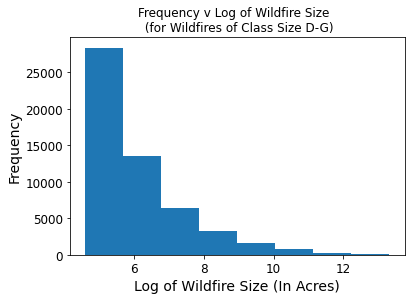

In [96]:
# With numpy, take a log transformation of 'FIRE_SIZE' column in limit_data_df
# Use plt.hist(data,bins=n) to plot this transformed column feature with a total of 'n' bins
data = np.log(limit_data_df['FIRE_SIZE'])

n=8
plt.hist(data,bins=n)
plt.xlabel('Log of Wildfire Size (In Acres)')
plt.ylabel('Frequency')
plt.title("Frequency v Log of Wildfire Size  \n (for Wildfires of Class Size D-G)")
plt.show()

**Question #9:** Interpreting the histogram: How much more likely is a wildfire with size $S$ to occur than a wildfire with size $S^2$? Assume there is an inverse relationship between frequency and log of wildfire size. 

Hint: $f(S) \propto \frac{1}{\log(S)} \Rightarrow f(S) \cdot \log(S) =$ Constant

*\#It's a lot more likely a wildfire with size S to occure than that with size S^2. In particularly, it's about twice as likely.*

**Wildfires in Urban Areas**

Wildfires affect more than just rural, remote settings - in 2020 alone, wildfires claimed more than 30 lives and caused tens of billions of dollars in direct damages. As such, we are particularly interested in understanding how wildfires can affect populated areas. For instance, which urban areas are most susceptible to fires, and how large do the fires tend to be in each urban area?

In fact, the tools to do this sort of analysis are available right here in Python - using Pandas and some adjacent packages, we are able to answer the above questions, and more.

**GeoPandas**

In addition to Pandas, we'll be using GeoPandas, a package that borrows the syntax and formatting of Pandas dataframes, but extends them to incorporate spatial data as well (like what you've worked with in the Tableau recitation). This way, you'll be able to use similar operations to work with spatial data.

In [97]:
!pip install geopandas
!pip install pygeos
import geopandas as gpd

     |████████████████████████████████| 1.0MB 7.8MB/s 
     |████████████████████████████████| 14.8MB 238kB/s 
     |████████████████████████████████| 6.5MB 36.8MB/s 
     |████████████████████████████████| 2.1MB 8.2MB/s 


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [98]:
# dataframe of fires to use in GeoPandas
df = pd.read_sql_query("SELECT * FROM Fires", conn)
df

,OBJECTID,state,LATITUDE,LONGITUDE,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS
0,1,CA,40.036944,-121.005833,2005,0.10,A
1,2,CA,38.933056,-120.404444,2004,0.25,A
2,3,CA,38.984167,-120.735556,2004,0.10,A
3,4,CA,38.559167,-119.913333,2004,0.10,A
4,5,CA,38.559167,-119.933056,2004,0.10,A
...,...,...,...,...,...,...,...
1880460,1880461,CA,40.481637,-122.389375,2015,0.01,A
1880461,1880462,CA,37.617619,-120.938570,2015,0.20,A
1880462,1880463,CA,37.617619,-120.938570,2015,0.10,A
1880463,1880464,CA,37.672235,-120.898356,2015,2.00,B


**Importing Shapefiles**

We have provided a shapefile for urban areas in the United States. Shapefiles combine spatial representations of data points combined with an attribute table where each row contains data on a particular data point. GeoPandas converts this into a geodataframe, which is similar to an ordinary dataframe, but contains an extra column, `geometry`, that contains the spatial representation of that data point. Here, we read the urban areas shapefile with `geopandas.read_file()` into a geodataframe called `urban_areas`.

In [111]:
# shapefile containing boundaries of urban areas, as well as information about them
urban_areas = gpd.read_file("cb_2018_us_ua10_500k.shp")
urban_areas

,UACE10,AFFGEOID10,GEOID10,NAME10,LSAD10,UATYP10,ALAND10,AWATER10,geometry
0,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987..."
1,01819,400C100US01819,01819,"Alturas, CA",76,C,4933312,16517,"MULTIPOLYGON (((-120.54610 41.51264, -120.5459..."
2,22366,400C100US22366,22366,"Davenport, IA--IL",75,U,357345121,21444164,"MULTIPOLYGON (((-90.36678 41.53636, -90.36462 ..."
3,93322,400C100US93322,93322,"Waynesboro, PA--MD",76,C,45455957,88872,"MULTIPOLYGON (((-77.50746 39.71577, -77.50605 ..."
4,02548,400C100US02548,02548,"Angola, IN",76,C,23646957,3913803,"MULTIPOLYGON (((-85.01157 41.59300, -85.00589 ..."
...,...,...,...,...,...,...,...,...,...
3596,57395,400C100US57395,57395,"Milton, DE",76,C,3147288,167254,"POLYGON ((-75.32719 38.77206, -75.31976 38.776..."
3597,85390,400C100US85390,85390,"Sugarmill Woods, FL",76,C,27203875,0,"MULTIPOLYGON (((-82.51716 28.75400, -82.51339 ..."
3598,46639,400C100US46639,46639,"Lake Conroe Eastshore, TX",76,C,18747170,63639,"MULTIPOLYGON (((-95.57872 30.40884, -95.57692 ..."
3599,15886,400C100US15886,15886,"Checotah, OK",76,C,3259478,0,"POLYGON ((-95.53799 35.47168, -95.53998 35.472..."


As you can see below, each row in the `urban_areas` geodataframe contains data and the shape for a particular urban area. Here, we illustrate this with a map of the Ithaca urban area, as well as the New York urban area

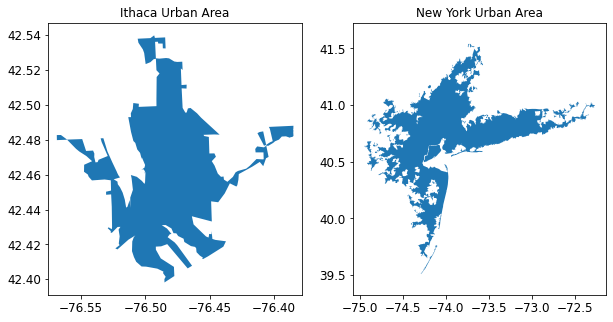

In [100]:
# plotting the Ithaca and New York urban areas
# plotting them as side-by-side subplots, with different titles
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.set_aspect('equal', adjustable='datalim')
ax2.set_aspect('equal', adjustable='datalim')
ax1.set_title("Ithaca Urban Area")
ax2.set_title("New York Urban Area")
urban_areas.loc[urban_areas["NAME10"] == "Ithaca, NY"].plot(ax=ax1)
urban_areas.loc[urban_areas["NAME10"] == "New York--Newark, NY--NJ--CT"].plot(ax=ax2)

**Converting Dataframes to Geodataframes**

In order to use spatial operations on existing spatial data that we have in a Pandas dataframe, we need to convert the dataframe into a geodataframe. Use `geopandas.GeoDataFrame()` to convert `df` into a geodataframe, `df_geo`. 

Here, we use `geopandas.GeoDataFrame()` to set the longitude and latitude columns of the original dataframe to be the `geometry` field of the corresponding geodataframe. Note: `geopandas.points_from_xy()` should be used here to convert longitude and latitude (corresponding to x and y, respectively) into a form that can be used by `geopandas.GeoDataFrame()`.

In [101]:
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))
df_geo

,OBJECTID,state,LATITUDE,LONGITUDE,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,geometry
0,1,CA,40.036944,-121.005833,2005,0.10,A,POINT (-121.00583 40.03694)
1,2,CA,38.933056,-120.404444,2004,0.25,A,POINT (-120.40444 38.93306)
2,3,CA,38.984167,-120.735556,2004,0.10,A,POINT (-120.73556 38.98417)
3,4,CA,38.559167,-119.913333,2004,0.10,A,POINT (-119.91333 38.55917)
4,5,CA,38.559167,-119.933056,2004,0.10,A,POINT (-119.93306 38.55917)
...,...,...,...,...,...,...,...,...
1880460,1880461,CA,40.481637,-122.389375,2015,0.01,A,POINT (-122.38938 40.48164)
1880461,1880462,CA,37.617619,-120.938570,2015,0.20,A,POINT (-120.93857 37.61762)
1880462,1880463,CA,37.617619,-120.938570,2015,0.10,A,POINT (-120.93857 37.61762)
1880463,1880464,CA,37.672235,-120.898356,2015,2.00,B,POINT (-120.89836 37.67223)


**Projections**

Spatial data is generally found in a particular projection - its projection determines what coordinate system the data represents (for instance, Latitude/Longitude, meters, feet, etc.), as well as how the data will be plotted on maps and visualizations. We won't go into much detail about projections, but be aware that you should generally use the same projection across data that you want to do spatial operations together on.

Notice how the shape of North America in the maps below are distorted in despite ways depending on the projection, despite representing the same underlying shape.

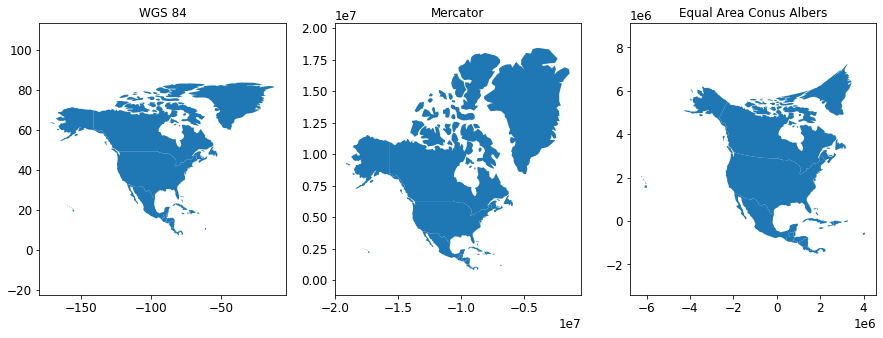

In [102]:
# reading a shapefile containing countries of the world in (included by default with GeoPandas)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# filtering out countries outside of North America
n_america = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world["continent"] == "North America"]
# setting datasets with different projections
n_america_mercator = n_america.to_crs(epsg=3857)
n_america_eq_area_albers = n_america.to_crs(epsg=5070)

# plotting the three differently-projected versions of the data side-by-side, with different titles
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
ax1.set_aspect('equal', adjustable='datalim')
ax2.set_aspect('equal', adjustable='datalim')
ax3.set_aspect('equal', adjustable='datalim')
ax1.set_title("WGS 84")
ax2.set_title("Mercator")
ax3.set_title("Equal Area Conus Albers")
n_america.plot(ax=ax1, aspect="auto")
n_america_mercator.plot(ax=ax2, aspect="auto")
n_america_eq_area_albers.plot(ax=ax3, aspect="auto")

**Question #10:** Why would you need to ensure that the projection is the same across all the data that you use? (Hint: look at the coordinates of the axes)

*\#because different projections might distort the view and affect our judgement*

The urban areas dataframe already has a projection (use `your_geodataframe.crs` to see).

In [112]:
print(urban_areas.crs)

epsg:4269


In [113]:
urban_areas.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

**Question #11:** What projection did the urban areas shapefile originally have?

*\#NAD83*

Let's convert it to the standard "WGS 84" projection. Use `your_geodataframe.to_crs()` to change the projection, and be sure to save the result to a variable, as the changed geodataframe will not automatically modify the original dataframe.

The EPSG code (a standard method to refer to projections in GeoPandas and elsewhere) for WGS 84 is *4326*

In [108]:
urban_areas = urban_areas.to_crs(epsg=4326)
print(urban_areas.crs)

epsg:4326


On the other hand, the geodataframe from our original wildfire dataset doesn't have a projection at all, since we derived X and Y from longitude and latitude (as opposed to pulling it from a shapefile that was already projected). We'll have to add a projection to the geodataframe by using `set_crs()` instead.

This time, we use `your_geodataframe.set_crs()`, and set it to be WGS 84 (EPSG: 4326) as well, since that projection also uses longitude and latitude as units.

In [114]:
print(df_geo.crs)
df_geo = df_geo.set_crs(epsg=4326)
print(df_geo.crs)

None
epsg:4326


**Spatial Joins**

Spatial joins act similarly to the joins we've used before, but they use spatial operators to determine how to join two dataset.

Instead of operators such as `>`, `<` and `=`, spatial joins have a different set of operators.
- intersects (left hand shape at least partially intersects with right hand shape)
- contains (right hand shape entirely falls within left hand shape)
- within (left hand shape entirely falls within right hand shape)
- touches (if shapes touch at a point but don't intersect beyond that)
- crosses (if the dimension of the intersection is less than the dimension of the one or the other, e.g. line intersecting a polygon)
- overlaps (if shapes intersect, but not entirely for either shape)

Here, we use `gpd.sjoin()` to keep only the rows of the wildfire geodataframe whose point locations are inside of (i.e. intersects) urban areas.

In [115]:
# inner joining urban areas to df_geo, based the urban area that each fire's point location intersects
df_geo_join_urban = gpd.sjoin(df_geo, urban_areas, how="inner", op='intersects')
df_geo_join_urban

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  


,OBJECTID,state,LATITUDE,LONGITUDE,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,geometry,index_right,UACE10,AFFGEOID10,GEOID10,NAME10,LSAD10,UATYP10,ALAND10,AWATER10
109,110,CA,33.718889,-117.433611,2005,10.00,C,POINT (-117.43361 33.71889),303,75340,400C100US75340,75340,"Riverside--San Bernardino, CA",75,U,1412019715,7618764
11208,11209,CA,33.766389,-117.489167,2006,0.10,A,POINT (-117.48917 33.76639),303,75340,400C100US75340,75340,"Riverside--San Bernardino, CA",75,U,1412019715,7618764
11211,11212,CA,33.799722,-117.511111,2006,14.00,C,POINT (-117.51111 33.79972),303,75340,400C100US75340,75340,"Riverside--San Bernardino, CA",75,U,1412019715,7618764
12827,12828,CA,33.766389,-117.509444,2006,0.01,A,POINT (-117.50944 33.76639),303,75340,400C100US75340,75340,"Riverside--San Bernardino, CA",75,U,1412019715,7618764
13435,13436,CA,34.205000,-117.343889,2006,0.10,A,POINT (-117.34389 34.20500),303,75340,400C100US75340,75340,"Riverside--San Bernardino, CA",75,U,1412019715,7618764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873317,1873318,CA,37.641838,-120.751417,2015,0.01,A,POINT (-120.75142 37.64184),1075,92539,400C100US92539,92539,"Waterford, CA",76,C,6643866,78956
1874149,1874150,CA,37.620347,-120.751081,2014,0.10,A,POINT (-120.75108 37.62035),1075,92539,400C100US92539,92539,"Waterford, CA",76,C,6643866,78956
1874819,1874820,CA,37.638504,-120.767089,2013,0.01,A,POINT (-120.76709 37.63850),1075,92539,400C100US92539,92539,"Waterford, CA",76,C,6643866,78956
1876786,1876787,CA,37.640995,-120.758510,2013,0.01,A,POINT (-120.75851 37.64100),1075,92539,400C100US92539,92539,"Waterford, CA",76,C,6643866,78956


**Grouping the Database by Urban Area**

From this new joined dataset, we can now associate each fire with a particular urban area. Let's use summary tools in GeoPandas to group the dataset by urban area name (`"NAME10"`), and get the fire count for each urban area.

You can do a group-by using df.groupby(), and counts can be obtained using df.count()

In [116]:
# We're getting the count of of fires, grouped by NAME10
# Pandas/GeoPandas calculates the counts for all the columns by default (unlike the syntax in SQL)
# so we select the OBJECTID column since a count of non-missing values in that column works for our purposes
# sorting in descending order
urban_fire_counts = df_geo_join_urban.groupby("NAME10").count().sort_values(by=['OBJECTID'], ascending=False)[["OBJECTID"]]
# renaming (counts of) OBJECTID to NUM_FIRES
urban_fire_counts = urban_fire_counts.rename(columns={'OBJECTID': 'NUM_FIRES'})
urban_fire_counts

,NUM_FIRES
NAME10,
"New York--Newark, NY--NJ--CT",33427
"Riverside--San Bernardino, CA",6717
"Urban Honolulu, HI",4897
"Atlanta, GA",4841
"Rochester, NY",3633
...,...
"Clear Lake, IA",1
"Menomonie, WI",1
"Fort Stockton, TX",1


**Question 12:** Which urban areas are in the top 3 in terms of fire count? Is there anything about these urban areas that could explain why their fire count is so high? *Hint:* consider why New York and its suburbs would be number 1?

You can use the table below (consisting of the above table, joined onto the urban_areas dataset) to see if anything is notable about some of the top places vs the bottom ones.

*Top 3 are New York -- Newark, Riverside -- San Bernardino, and Urban Honolulu. The fiere count is so high because they are big cities and population is dense there.*

In [117]:
# doing an inner join between urban_fire_counts and urban_areas dataset, based on the name of the urban area
# saving it to urban_fire_counts_joined because we will use this later
urban_fire_counts_joined = urban_fire_counts.merge(urban_areas, how="inner", on='NAME10')
urban_fire_counts_joined

,NAME10,NUM_FIRES,UACE10,AFFGEOID10,GEOID10,LSAD10,UATYP10,ALAND10,AWATER10,geometry
0,"New York--Newark, NY--NJ--CT",33427,63217,400C100US63217,63217,75,U,8934084608,534984232,"MULTIPOLYGON (((-72.35716 40.90963, -72.35495 ..."
1,"Riverside--San Bernardino, CA",6717,75340,400C100US75340,75340,75,U,1412019715,7618764,"MULTIPOLYGON (((-116.85224 33.95074, -116.8333..."
2,"Urban Honolulu, HI",4897,89770,400C100US89770,89770,75,U,440034686,13084141,"MULTIPOLYGON (((-157.89224 21.30929, -157.8919..."
3,"Atlanta, GA",4841,03817,400C100US03817,03817,75,U,6851581056,93257528,"MULTIPOLYGON (((-83.71458 34.10093, -83.71320 ..."
4,"Rochester, NY",3633,75664,400C100US75664,75664,75,U,840006639,17285006,"MULTIPOLYGON (((-77.31627 42.88764, -77.30474 ..."
...,...,...,...,...,...,...,...,...,...,...
2472,"Clear Lake, IA",1,17506,400C100US17506,17506,76,C,17482377,44401,"MULTIPOLYGON (((-93.34962 43.16970, -93.31995 ..."
2473,"Menomonie, WI",1,56224,400C100US56224,56224,76,C,30157850,4438867,"POLYGON ((-91.94704 44.89885, -91.94567 44.899..."
2474,"Fort Stockton, TX",1,30952,400C100US30952,30952,76,C,15366151,0,"MULTIPOLYGON (((-102.85032 30.88467, -102.8458..."
2475,"Rock Valley, IA",1,75907,400C100US75907,75907,76,C,4062966,0,"MULTIPOLYGON (((-96.27528 43.21105, -96.27377 ..."


*Note:* As seen above, non-spatial joins in Pandas/GeoPandas (like the ones you've done in SQL) are done using he `merge()` function. You can specify the type of join (left, right, inner, etc.) using the `how` parameter, as well as the field to join on using the `on` parameter. If the field on the left table has a different name than the corresponding field on the right table, use `left_on` and `right_on` to specify field names.

**Normalizing by Area**

The previous method of ranking urban area penalizes smaller urban areas. Let's normalize by land area to see if that produces a more helpful metric. To get land area for these cities, we'll use `urban_fire_counts_joined`, which we created in the previous code block using a inner join with the summaries and the original table.

Also note that the unit of `ALAND10` is meters squared - there are $2.59\times10^6$ square meters in a square mile.

In [118]:
# calculating area in square miles and saving that to a new column
urban_fire_counts_joined["ALAND10_SQMI"] = urban_fire_counts_joined["ALAND10"] / 2.59e+6
# generating a new column for fires per square mile
urban_fire_counts_joined["NUM_FIRES_PER_SQMI"] = urban_fire_counts_joined["NUM_FIRES"] / urban_fire_counts_joined["ALAND10_SQMI"]
# sorting the table in descending order
urban_fire_counts_joined.sort_values(by=['NUM_FIRES_PER_SQMI'], ascending=False)

,NAME10,NUM_FIRES,UACE10,AFFGEOID10,GEOID10,LSAD10,UATYP10,ALAND10,AWATER10,geometry,ALAND10_SQMI,NUM_FIRES_PER_SQMI
24,"Pine Ridge, SD",1496,69535,400C100US69535,69535,76,C,2895683,0,"MULTIPOLYGON (((-102.54706 43.03165, -102.5470...",1.118024,1338.074644
56,"Poplar, MT",681,70777,400C100US70777,70777,76,C,3471107,0,"POLYGON ((-105.21638 48.11581, -105.21450 48.1...",1.340196,508.134725
15,"San Carlos, AZ",2097,78607,400C100US78607,78607,76,C,10801984,1106,"MULTIPOLYGON (((-110.45763 33.29733, -110.4554...",4.170650,502.799301
84,"Browning, MT",455,10864,400C100US10864,10864,76,C,4860599,72933,"POLYGON ((-113.03436 48.54131, -113.03092 48.5...",1.876679,242.449542
160,"North Eagle Butte, SD",257,63588,400C100US63588,63588,76,C,3531341,0,"POLYGON ((-101.24189 44.99998, -101.24125 45.0...",1.363452,188.492134
...,...,...,...,...,...,...,...,...,...,...,...,...
1973,"Cincinnati, OH--KY--IN",3,16885,400C100US16885,16885,75,U,2040396726,24339712,"MULTIPOLYGON (((-84.05054 39.05261, -84.05048 ...",787.797964,0.003808
2130,"Milwaukee, WI",2,57466,400C100US57466,57466,75,U,1413151381,49351861,"MULTIPOLYGON (((-87.92842 43.30931, -87.92522 ...",545.618294,0.003666
2193,"Akron, OH",1,00766,400C100US00766,00766,75,U,842815514,17431799,"MULTIPOLYGON (((-81.30012 41.16281, -81.29977 ...",325.411395,0.003073
2145,"Cleveland, OH",2,17668,400C100US17668,17668,75,U,2004098980,11901959,"MULTIPOLYGON (((-81.09328 41.76613, -81.09313 ...",773.783390,0.002585


**Question 13:** Which urban areas are in the top 3 in terms of fire count per square mile? How does this differ from the top 3 in the previous question? Is this method also biased towards certain urban areas?

*Top 3 are Pine Ridge, Poplar, and San Carlos. These are smaller cities. This method might be biased toward urban areas in the midwest. *



In the homework, we'll revise this analysis to get rid of some of this bias towards urban areas with sizes on either extreme.